In [1]:

import os
import sys
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt, ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pysar.simulation.plot import *
from pysar.objects import timeseries, ifgramStack, sensor, gps
from pysar.utils import readfile, writefile, ptime, plot as pp, utils as ut, network as pnet
from pysar.utils.insar_vs_gps import insar_vs_gps
from pysar import view, ifgram_inversion as ifginv

work_dir = os.path.expanduser('~/development/python/2018_ComputGeosci_PySAR/network_redundancy')
os.chdir(work_dir)
print('Go to directory: '+work_dir)
gps_dir = os.path.expanduser('~/insarlab/Galapagos/GPS')
site_names = ['GV{:02d}'.format(i) for i in [1] + np.arange(3,11).tolist()]
ref_site = 'GV01'

proj_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128_30CONN/PYSAR')
proj_name = sensor.project_name2sensor_name(proj_dir)[1]
ifgram_file = os.path.join(proj_dir, 'INPUTS/ifgramStack.h5')
geom_file = os.path.join(proj_dir, 'INPUTS/geometryRadar.h5')
trop_file = os.path.join(proj_dir, 'INPUTS/ECMWF.h5')

out_file = 'data.pickle'

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/network_redundancy


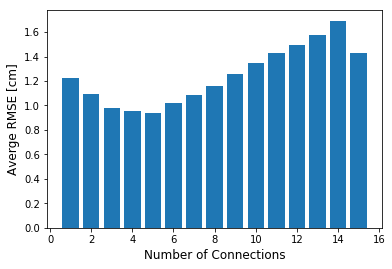

In [91]:
## Read / Generate data
if not os.path.isfile(out_file):
    dsDict = {}
    for i in range(1,16):
        conn = '{:02d}CONN'.format(i)
        print(conn)
        ts_file       = os.path.join(proj_dir, conn, 'timeseries.h5')
        temp_coh_file = os.path.join(proj_dir, conn, 'temporalCoherence.h5')
        obj = insar_vs_gps(ts_file, geom_file, temp_coh_file, site_names, gps_dir, ref_site)
        obj.open()
        dsDict[conn] = dict(obj.ds)
    
    with open(out_file, 'wb') as f:
        pickle.dump(dsDict, f)
    print('Saved to pickle file {}.'.format(out_file))
else:
    with open(out_file, 'rb') as f:
        dsDict = pickle.load(f)

conn_list = sorted(list(dsDict.keys()))
num_conn = len(conn_list)
site_names = sorted(list(dsDict[conn_list[2]].keys()))

site2plot = ['GV{:02d}'.format(i) for i in [5, 4, 6, 9, 3, 8, 7, 10]]
site2plot = site_names
site2plot.remove('GV01')
#site2plot.remove('GV08')
site2plot.remove('GV10')
num_site = len(site2plot)

rmse = np.zeros((num_conn, num_site))
for i in range(num_conn):
    ds = dsDict[conn_list[i]]
    for j in range(num_site):
        site = ds[site2plot[j]]
        rmse[i, j] = site['dis_rmse']
rmse *= 100.  #[cm]

tcoh = np.zeros((num_conn, num_site))
for i in range(num_conn):
    ds = dsDict[conn_list[i]]
    for j in range(num_site):
        site = ds[site2plot[j]]
        tcoh[i, j] = site['temp_coh']

rmse[tcoh < 0.7] = np.nan
plt.figure()
plt.bar(np.arange(1, num_conn+1), np.nanmean(rmse, axis=1))
plt.xlabel('Number of Connections', fontsize=font_size)
plt.ylabel('Averge RMSE [cm]', fontsize=font_size)
plt.show()

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


data min/max: nan/nan


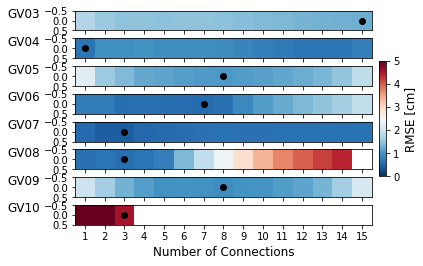

In [88]:
## RMSE 
fig, axs = plt.subplots(figsize=[5, 4], nrows=len(site2plot), ncols=1, sharex=True, sharey=True)
for j in range(len(site2plot)):
    ax = axs[j]
    sname = site2plot[j]
    data = rmse[:, site_names.index(sname)].reshape(1,-1)
    im = ax.imshow(data, cmap='RdBu_r', vmin=0, vmax=5)
    
    ax.plot(np.nanargmin(data), 0, 'ko')
    ax.annotate(sname, rotation=0, labelpad=20, fontsize=font_size)
    ax.set_xticks(np.arange(0, num_conn));
    ax.set_xticklabels(np.arange(1, num_conn+1));
axs[-1].set_xlabel('Number of Connections', fontsize=font_size)

dmin = np.min(rmse[:, :-1])
dmax = np.max(rmse[:, :-1])
print('data min/max: {}/{}'.format(dmin, dmax))

## colorbar
fig.subplots_adjust(right=0.95)
cax = fig.add_axes([0.97, 0.3, 0.02, 0.4])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('RMSE [cm]', fontsize=font_size)

#plt.savefig('rmse_numConn.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

data min/max: 0.6995712091408242/1.0


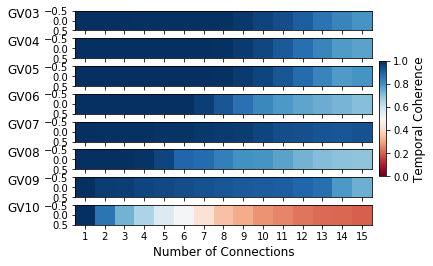

In [90]:
# temporal coherence
fig, axs = plt.subplots(figsize=[5, 4], nrows=len(site2plot), ncols=1, sharex=True, sharey=True)
for j in range(len(site2plot)):
    ax = axs[j]
    sname = site2plot[j]
    data = tcoh[:, site_names.index(sname)].reshape(1,-1)
    im = ax.imshow(data, cmap='RdBu', vmin=0, vmax=1)
    ax.set_ylabel(sname, rotation=0, labelpad=20, fontsize=font_size)
    ax.set_xticks(np.arange(0, num_conn));
    ax.set_xticklabels(np.arange(1, num_conn+1));
axs[-1].set_xlabel('Number of Connections', fontsize=font_size)

dmin = np.min(tcoh[:, :-1])
dmax = np.max(tcoh[:, :-1])
print('data min/max: {}/{}'.format(dmin, dmax))

## colorbar
fig.subplots_adjust(right=0.95)
cax = fig.add_axes([0.97, 0.3, 0.02, 0.4])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Temporal Coherence', fontsize=font_size)

#plt.savefig('tempCoh_numConn.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

In [2]:
# GPS site info
crnr_lats = [float(stack_obj.metadata['LAT_REF{}'.format(i)]) for i in [1,2,3,4]]
crnr_lons = [float(stack_obj.metadata['LON_REF{}'.format(i)]) for i in [1,2,3,4]]
SNWE = (min(crnr_lats), max(crnr_lats), min(crnr_lons), max(crnr_lons))
date0 = stack_obj.dateList[0]
date1 = stack_obj.dateList[-1]
site_names, site_lats, site_lons = gps.search_gps(SNWE, start_date=date0, end_date=date1)

# read InSAR stack on GPS sites
coord = ut.coordinate(stack_obj.metadata, geom_file)
ifgs = {}
trops = {}
num_site = len(site_names)
for i in range(num_site):
    sys.stdout.write('\rreading ifgramStack on {}'.format(site_names[i]))
    sys.stdout.flush()
    # read ifgramStack
    ifg = {}
    ifg['site_name'] = site_names[i]
    ifg['site_lat'] = site_lats[i]
    ifg['site_lon'] = site_lons[i]
    y, x = coord.geo2radar(site_lats[i], site_lons[i])[0:2]
    box = (x, y, x+1, y+1)
    ifg['unwrapPhase'] = readfile.read(ifgram_file, datasetName='unwrapPhase', box=box)[0].flatten()
    ifg['coherence']   = readfile.read(ifgram_file, datasetName='coherence',   box=box)[0].flatten()
    ifgs[site_names[i]] = ifg

    # read trop delay
    trops[site_names[i]] = readfile.read(trop_file, box=box)[0].flatten()
print('')

# reference site
ref_site = 'GV01'
ref_phase = ifgs[ref_site]['unwrapPhase']
ref_trop = trops[ref_site]
for i in range(num_site):
    ifgs[site_names[i]]['unwrapPhase'] -= ref_phase
    trops[site_names[i]] -= ref_trop
print('Done.')

reading ifgramStack on GV10
Done.


In [3]:
num_conn = 5
site = 'GV05'

def estimate_insar_dis(site_name, num_conn=5):
    # modify network
    date12_list = pnet.select_pairs_sequential(date_list, num_conn, date12_format='YYYYMMDD_YYYYMMDD')
    flag = np.array([i in date12_list for i in date12_list_all])
    print('number of interferograms used: {}'.format(sum(flag)))
    
    # invert for raw phase time-series
    A, B = stack_obj.get_design_matrix4timeseries_estimation(date12_list=date12_list)[0:2]
    ifg = ifgs[site]
    unw = ifg['unwrapPhase'][flag]
    cor = ifg['coherence'][flag]
    wei_sqrt = np.sqrt(ifginv.coherence2weight(cor, weight_func='var', L=L, print_msg=False))
    ts, tcoh = ifginv.estimate_timeseries(A, B, tbase_diff, unw, wei_sqrt)[0:2]
    ts *= phase2range
    ts = ts.flatten()

    # correct for tropospheric delay
    ts -= trops[site]
    return ts, tcoh

def get_ts_rmse(site_name, num_conn, display=False):
    # get GPS time-series
    gps_obj = gps.GPS(site_name, data_dir=gps_dir)
    gps_dates, gps_dis = gps_obj.read_gps_los_displacement(geom_file, date0, date1,
                                                           ref_site=ref_site, gps_comp='enu2los')[0:2]

    # get InSAR time-series
    insar_dis, tcoh = estimate_insar_dis(site_name, num_conn)

    # reference date
    insar_idx = 2
    while insar_idx < len(insar_dates):
        if insar_dates[insar_idx] not in gps_dates:
            insar_idx += 1
        else:
            break
    if insar_idx == len(insar_dates):
        raise RuntimeError('InSAR and GPS do not share ANY date for site: {}'.format(site_name))
    ref_date = insar_dates[insar_idx]
    insar_dis -= insar_dis[insar_idx]
    gps_idx = np.where(gps_dates == ref_date)[0][0]
    gps_dis -= gps_dis[gps_idx]

    if display:
        plt.figure()
        plt.plot(gps_dates, gps_dis, '.', ms=0.2)
        plt.plot(insar_dates, insar_dis, 'o', mfc='none', ms=4)
        plt.show()

    # calculate RMSE
    comm_dates = np.array(sorted(list(set(gps_dates) & set(insar_dates))))
    num_comm_date = len(comm_dates)
    dis_diff = np.zeros(num_comm_date, np.float32)
    for i in range(num_comm_date):
        comm_date = comm_dates[i]
        sys.stdout.write('\r{}'.format(comm_date))
        sys.stdout.flush()
        idx1 = list(gps_dates).index(comm_date)
        idx2 = list(insar_dates).index(comm_date)
        dis_diff[i] = gps_dis[idx1] - insar_dis[idx2]
    dis_rmse = np.sqrt(np.sum(np.square(dis_diff)) / (num_comm_date - 1))
    return dis_rmse

number of interferograms used: 925


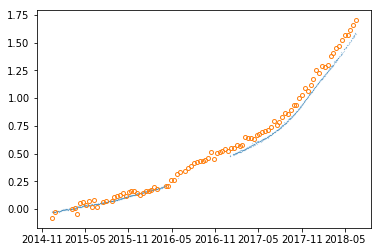

2018-06-07 00:00:00

0.06335242816308703

In [4]:
get_ts_rmse('GV05', 10, display=True)

In [ ]:
gps_dates

In [10]:
## Maximum detectable deformation gradient
# D. Massonnet and K. L. Feigl, “Radar interferometry and its applica- tion to changes in the earth’s surface,” Rev. Geophys., vol. 36, no. 4, pp. 441–500, 1998.
# dmax = wavelength / (2 * pixel_size)

atr = dict(stack_obj.metadata)
pixel_size_rg = ut.range_ground_resolution(atr)
pixel_size_az = ut.azimuth_ground_resolution(atr)
wavelength = float(atr['WAVELENGTH'])
wavelength / (2 * pixel_size_rg)

0.00043144018132447215

In [11]:
pixel_size_az, pixel_size_rg

(70.32401354183635, 64.27978014208881)